In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [71]:
df= pd.read_csv('../input/muprice/mu(lstm).csv',encoding='cp949')
df.head()

,date,gangsu,ondo,snow,price
0,2015-01-02,0.8,-5.2,1.0,445
1,2015-01-05,9.8,2.5,0.0,450
2,2015-01-06,5.1,1.6,0.0,450
3,2015-01-07,0.0,-3.9,0.0,450
4,2015-01-08,0.0,-3.5,0.0,450


In [72]:
snow=df['snow']
ondo=df['ondo']
gangsu=df['gangsu']
price=df['price']
date=['date']

Text(0.5, 1.0, 'price')

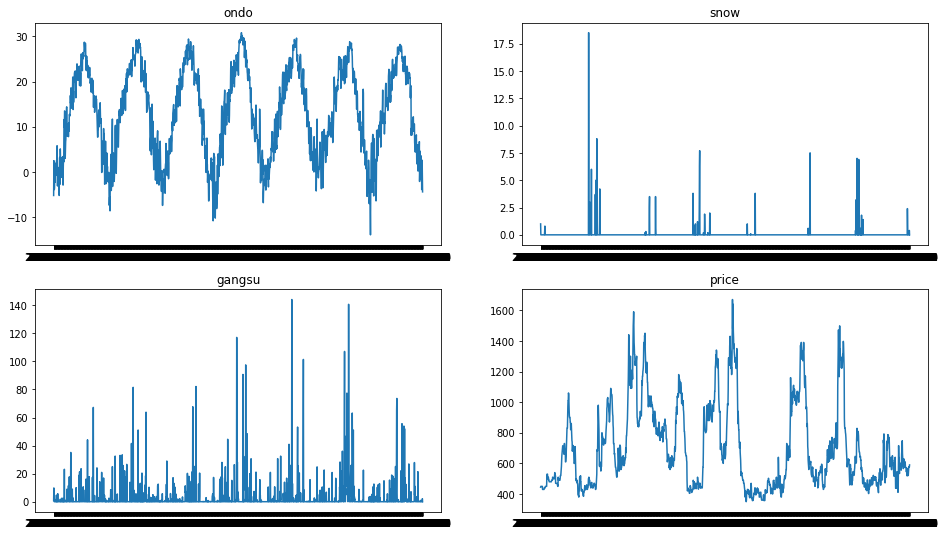

In [73]:
plt.figure(figsize=(16, 9))
plt.subplot(221)
plt.plot(df['date'], df['ondo'],label='ondo')
plt.title('ondo')

plt.subplot(222)
plt.plot(df['date'], df['snow'],label='uga')
plt.title('snow')

plt.subplot(223)
plt.plot(df['date'], df['gangsu'],label='gangsu')
plt.title('gangsu')

plt.subplot(224)
plt.plot(df['date'], df['price'],label='price')
plt.title('price')

In [74]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['snow', 'ondo', 'gangsu', 'price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.05405405, 0.19463087, 0.0055517 , 0.0719697 ],
       [0.        , 0.36689038, 0.06800833, 0.07575758],
       [0.        , 0.34675615, 0.03539209, 0.07575758],
       ...,
       [0.        , 0.36912752, 0.        , 0.17272727],
       [0.02162162, 0.30425056, 0.01457321, 0.17121212],
       [0.        , 0.21252796, 0.        , 0.18181818]])

In [75]:
df = pd.DataFrame(scaled, columns=scale_cols)
df

,snow,ondo,gangsu,price
0,0.054054,0.194631,0.005552,0.071970
1,0.000000,0.366890,0.068008,0.075758
2,0.000000,0.346756,0.035392,0.075758
3,0.000000,0.223714,0.000000,0.075758
4,0.000000,0.232662,0.000000,0.075758
...,...,...,...,...
1717,0.000000,0.223714,0.000000,0.165152
1718,0.000000,0.348993,0.000000,0.172727
1719,0.000000,0.369128,0.000000,0.172727
1720,0.021622,0.304251,0.014573,0.171212


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[['ondo', 'gangsu', 'snow']],df['price'],test_size=0.2, random_state=12, shuffle=False)

In [77]:
x_train.shape, y_train.shape

((1377, 3), (1377,))

In [78]:
x_test.shape, y_test.shape

((345, 3), (345,))

In [79]:
x_train

,ondo,gangsu,snow
0,0.194631,0.005552,0.054054
1,0.366890,0.068008,0.000000
2,0.346756,0.035392,0.000000
3,0.223714,0.000000,0.000000
4,0.232662,0.000000,0.000000
...,...,...,...
1372,0.930649,0.015961,0.000000
1373,0.928412,0.000000,0.000000
1374,0.908277,0.139486,0.000000
1375,0.890380,0.279667,0.000000


In [80]:
y_test

1377    0.352273
1378    0.390152
1379    0.390152
1380    0.331061
1381    0.285606
          ...   
1717    0.165152
1718    0.172727
1719    0.172727
1720    0.171212
1721    0.181818
Name: price, Length: 345, dtype: float64

In [81]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [82]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [83]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [84]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Bidirectional,Dropout,BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    Conv1D(filters=32, kernel_size=3,
           padding="causal",
           activation="relu"),
    # LSTM
    LSTM(16, activation='tanh',return_sequences = True),
    LSTM(32, activation='relu',return_sequences = True),
    LSTM(64, activation='relu',return_sequences = True),
    Bidirectional(LSTM(128, activation='relu',return_sequences = True)),
    Bidirectional(LSTM(256, activation='relu',return_sequences = False)),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [86]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
optimizer = Adam(0.0005)
model.compile(loss = Huber(), optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [87]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [88]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=200, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
43/43 [==============================] - 18s 275ms/step - loss: 0.0239 - root_mean_squared_error: 0.2187 - val_loss: 0.0065 - val_root_mean_squared_error: 0.1143

Epoch 00001: val_loss improved from inf to 0.00654, saving model to tmp/ckeckpointer.ckpt
Epoch 2/200
43/43 [==============================] - 10s 236ms/step - loss: 0.0093 - root_mean_squared_error: 0.1362 - val_loss: 0.0073 - val_root_mean_squared_error: 0.1204

Epoch 00002: val_loss did not improve from 0.00654
Epoch 3/200
43/43 [==============================] - 11s 244ms/step - loss: 0.0082 - root_mean_squared_error: 0.1280 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0962

Epoch 00003: val_loss improved from 0.00654 to 0.00462, saving model to tmp/ckeckpointer.ckpt
Epoch 4/200
43/43 [==============================] - 10s 227ms/step - loss: 0.0060 - root_mean_squared_error: 0.1094 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0871

Epoch 00004: val_loss improved from 0.00462 to 0.00379, saving mo

In [89]:
pred = model.predict(test_data)
pred.shape

(325, 1)

In [90]:
print(pred)

[[0.7351565 ]
 [0.7728964 ]
 [0.7261403 ]
 [0.71435   ]
 [0.7188272 ]
 [0.7362308 ]
 [0.7035441 ]
 [0.6663001 ]
 [0.7265928 ]
 [0.7138421 ]
 [0.6551196 ]
 [0.6803604 ]
 [0.72170866]
 [0.739525  ]
 [0.73715264]
 [0.76240885]
 [0.8025102 ]
 [0.77697927]
 [0.72834724]
 [0.6650312 ]
 [0.64594334]
 [0.39681247]
 [0.38405606]
 [0.36789867]
 [0.36796433]
 [0.3634331 ]
 [0.3358703 ]
 [0.31875739]
 [0.29985115]
 [0.27249417]
 [0.26037115]
 [0.21681628]
 [0.19712111]
 [0.19273496]
 [0.17385402]
 [0.18032053]
 [0.19285196]
 [0.20110402]
 [0.19772094]
 [0.2062333 ]
 [0.20692077]
 [0.2006889 ]
 [0.20851502]
 [0.18350363]
 [0.15066296]
 [0.11514147]
 [0.09252448]
 [0.11624309]
 [0.12821221]
 [0.18925518]
 [0.1669138 ]
 [0.16034618]
 [0.12173793]
 [0.12698963]
 [0.12833413]
 [0.10677595]
 [0.08698687]
 [0.09500285]
 [0.10008015]
 [0.09899331]
 [0.11982557]
 [0.13706028]
 [0.1396302 ]
 [0.13237095]
 [0.12518397]
 [0.12167747]
 [0.12344608]
 [0.1276603 ]
 [0.15430659]
 [0.16915205]
 [0.19315359]
 [0.22

In [91]:
print(y_test[20:])
print(y_test[20:].shape)

1397    0.755303
1398    0.716667
1399    0.707576
1400    0.700000
1401    0.715152
          ...   
1717    0.165152
1718    0.172727
1719    0.172727
1720    0.171212
1721    0.181818
Name: price, Length: 325, dtype: float64
(325,)


In [99]:
print(type(pred))

<class 'numpy.ndarray'>


In [102]:
pred1 = pd.DataFrame(pred)
 
pred1.to_csv('pred.csv', index=False)

In [103]:
y_test1=y_test[20:]

In [104]:
y_test1 = pd.DataFrame(y_test1)
 
y_test1.to_csv('y_test(mu).csv', index=False)

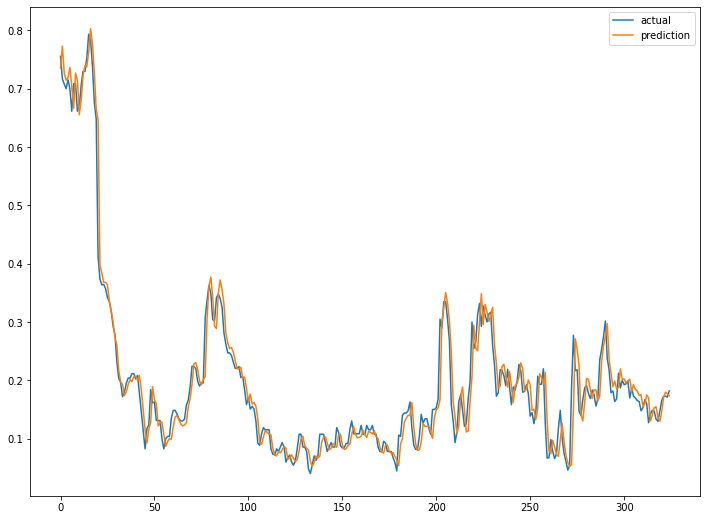

In [92]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [93]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

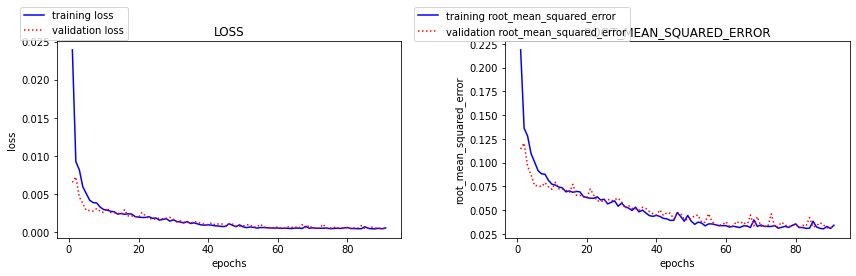

In [94]:
plot_history(history)

In [95]:
import tensorflow.keras as keras
x_test_t = x_test.values.reshape(x_test.shape[0], 3, 1)
y_test_t = y_test.values.reshape(y_test.shape[0], 1)


In [96]:
score=model.evaluate(x_test_t,y_test,batch_size=32)

11/11 [==============================] - 1s 7ms/step - loss: 0.0251 - root_mean_squared_error: 0.2240


In [97]:
model.save('mu(lstm)5.h5')

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

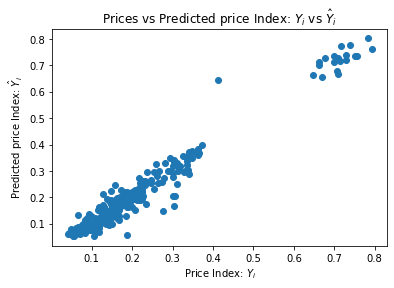

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt


y_pred = model.predict(train_data, batch_size=32)
plt.scatter(y_test[20:], pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")